In [580]:
# required libraries
import numpy as np
import pandas as pd
from dateutil.parser import ParserError
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from math import log2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [581]:
# chargement du dataset avec pandas
data = pd.read_csv('heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [582]:
data.shape

(918, 12)

In [583]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [584]:

def transform_data(data):
    label_encoder = LabelEncoder()
    list_features = list(data.columns)
    categorical = []
    numerical = []

    for i in list_features:
        if len(data[i].unique())>5: 
                numerical.append(i)
        else:
                categorical.append(i)

    for i in categorical :
        data[i]=label_encoder.fit_transform(data[i])

In [585]:
transform_data(data)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


In [586]:
# Target
def get_data(_data, target_column):
    y = np.array(_data[target_column])
    X = list()
    for feature in list(_data.columns):
        X.append(list(_data[feature]))
    X  = np.array(X[:-1]).T
    return X, y


***On commence par réduire le nombre de dimention de 11 à 2 afin de pouvoir afficher les données***


In [587]:
number_of_features = X.shape[1]

classes = np.unique(y)

number_of_classes = len(classes)

print(f"le nombre de features est : ", number_of_features)
print(f"le nombre de classes est : ", number_of_classes)



le nombre de features est :  30
le nombre de classes est :  2


In [588]:



#Calcul de la moyenne des features
means = np.mean(X, 0)


In [589]:
# calcul des scatter matrix


S_w_matrix = np.zeros((number_of_features, number_of_features)) # initialize Within class scatter matrix:

S_b_matrix = np.zeros((number_of_features, number_of_features)) # initialize Between classes scatter matrix:

class_means = []
unique_classes = np.unique(y)
for c in unique_classes:
    class_mean = np.mean(X[y == c], axis=0)
    class_means.append(class_mean)


In [590]:
for c in unique_classes:
    # for each class calculate the 

    X_c = X[y==c]
    mean_c = np.mean(X_c, axis=0)

    S_w_matrix += (X_c - mean_c).T.dot((X_c - mean_c))

    n_c = X_c.shape[0]
    mean_diff = (mean_c - means).reshape(number_of_features, 1)
    S_b_matrix += n_c * (mean_diff).dot(mean_diff.T)

In [591]:



S = np.linalg.inv(S_w_matrix).dot(S_b_matrix)

eigen_values, eigen_vectors = np.linalg.eig(S)


# eigenvectors = eigen_vectors.T
# idxs = np.argsort(abs(eigen_values))[::-1]
# eigenvalues = eigen_values[idxs]
# eigenvectors = eigenvectors[idxs]

# store first 2 eigenvectors in case of (we assume that we want to reduce 3D to 2D)
# print(eigenvectors)
lda = eigen_vectors[:,0]
print(eigen_values)



# Project the data
res = np.dot(X, lda).reshape(-1,1)


x1 = res[:,0]
# x2 = res[:,1]

# plt.scatter(x1,y, c=y)

# lda_model = LinearDiscriminantAnalysis()
# lda_model.fit(X, y)
# X_lda = lda_model.transform(X)

# plt.scatter(X_lda,y, c=y)







[ 3.43114417e+00+0.00000000e+00j  9.02465456e-13+0.00000000e+00j
 -1.94630772e-13+0.00000000e+00j  5.70953565e-14+2.82926294e-14j
  5.70953565e-14-2.82926294e-14j -5.13561530e-14+2.05005045e-14j
 -5.13561530e-14-2.05005045e-14j -5.39258651e-15+4.02735264e-14j
 -5.39258651e-15-4.02735264e-14j  1.93814075e-14+0.00000000e+00j
 -1.29081149e-14+0.00000000e+00j  1.00075106e-14+2.80812044e-15j
  1.00075106e-14-2.80812044e-15j -5.81110392e-16+7.28724954e-15j
 -5.81110392e-16-7.28724954e-15j -6.88780567e-15+0.00000000e+00j
  6.37960845e-15+0.00000000e+00j  1.01878572e-16+3.05383220e-15j
  1.01878572e-16-3.05383220e-15j  2.57508366e-15+0.00000000e+00j
 -2.32578446e-15+0.00000000e+00j  9.47304416e-16+1.59664977e-15j
  9.47304416e-16-1.59664977e-15j -1.29189065e-15+0.00000000e+00j
  1.02120487e-15+0.00000000e+00j -7.10169313e-16+0.00000000e+00j
 -1.71297329e-16+0.00000000e+00j -3.38555336e-18+0.00000000e+00j
  1.52054739e-16+1.55598183e-17j  1.52054739e-16-1.55598183e-17j]


In [592]:
class MyLDA:
    def __init__(self):
        self.X = None
        self.y = None
        self.mean_class = {}
        self.class_covariance = {}
        self.covariance_matrix = None

    def fit(self, _X, _y):
        self.X = _X
        self.y = _y

        self.covariance_matrix = np.cov(_X, rowvar=False)
        unique_classes = np.unique(self.y)

        for c in unique_classes:
            class_samples = _X[_y == c]
            self.mean_class[c] = np.mean(class_samples, axis=0)

        for c in unique_classes:
            class_samples = _X[_y == c]
            self.class_covariance[c] = np.cov(class_samples, rowvar=False)


    def predict(self, test_data):
        inverse_covariance_matrix = np.linalg.inv(self.covariance_matrix)
        res = list()

        # compute delta_k(x) for each row in the 
        for line in test_data:
            deltas = list()
            classes = list()
            for m_class in self.mean_class:
                mean_c = self.mean_class[m_class]
                pi_k = len(self.X[self.y==m_class])/len(self.X)
                delta = np.dot(np.dot(line.T,inverse_covariance_matrix), mean_c) - 1/2 * np.dot(np.dot(mean_c.T,inverse_covariance_matrix), mean_c) + log2(pi_k)
                deltas.append(delta)
                classes.append(m_class)
            index = deltas.index(max(deltas))
            res.append(classes[index])

        return np.array(res)


In [593]:

def plot_confusion_matrix(y_test, prediction, title="Confusion Matrix"):
    c_matrix = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(c_matrix)
    plt.figure(figsize=(8,6))
    
    sns.heatmap(cm_df, annot=True, fmt='d', cmap=plt.cm.Greens)

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [594]:

def illustrate_result(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42) 

    model = MyLDA()
    model.fit(X_train,y_train)
    res = model.predict(X_test)

    print('The accuracy: ',accuracy_score(y_test, res))
    print('The precision: ',precision_score(y_test, res, average='macro'))
    print('The recall: ',recall_score(y_test, res, average='macro'))

    plot_confusion_matrix(y_test, res)
    

The accuracy:  0.8627450980392157
The precision:  0.8590404213901294
The recall:  0.8659404785061272


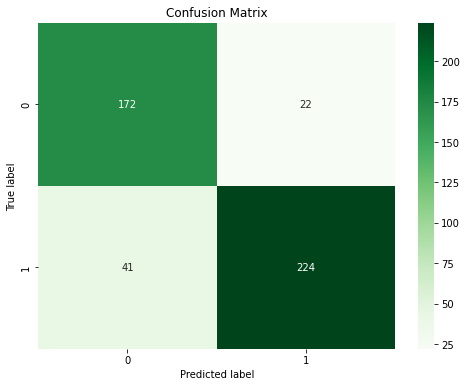

In [595]:
# on teste notre modèle sur le data set de heart.csv

X, y = get_data(data, 'HeartDisease')

illustrate_result(X,y)

The accuracy:  0.9662921348314607
The precision:  0.9729729729729729
The recall:  0.9696969696969697


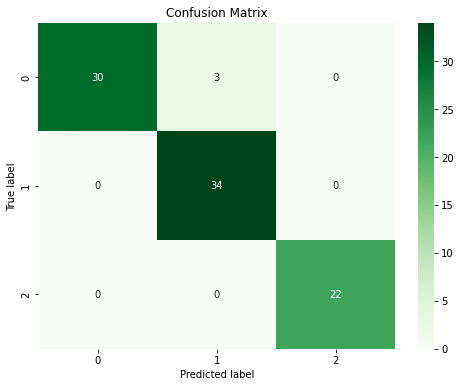

In [596]:
# Illustrons notre modèle sur le dataset wine de sklearn.datasets

wine = datasets.load_wine()
X = wine.data
y = wine.target

illustrate_result(X,y)

(569, 30)
The accuracy:  0.9438596491228071
The precision:  0.9567341862117982
The recall:  0.9207955909636583


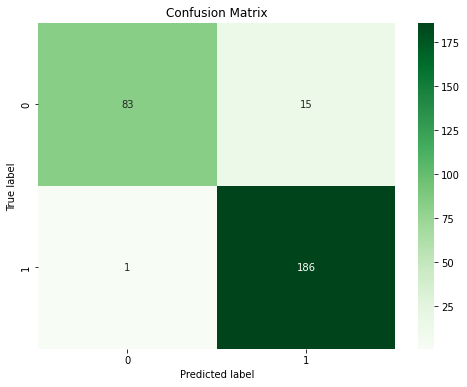

In [598]:
 # Illustrons ce que nous avons obtenu avec le dataset breast_cancer

cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

illustrate_result(X,y)
